In [1]:
import csv
import math
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from copy import deepcopy

In [2]:
def process_df(df):
  new_df = deepcopy(df)
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [3]:
def train_test_split_sample(df, startMonth, endMonth):
    sample_df = df[df.sale_month.isin(list(range(startMonth, endMonth)))]
    sample_X, sample_y = sample_df.drop('cpi_psm', axis=1), sample_df.cpi_psm
    return sample_X, sample_y

In [4]:
def train_test_split_year(df, lookback_years):
    latest_month = df.sale_month.max()
    test_months = list(range(latest_month - lookback_years * 12, latest_month + 1))
    train_months = list(range(1, latest_month - lookback_years * 12))

    train = df[df.sale_month.isin(train_months)]
    test = df[df.sale_month.isin(test_months)]
  
    X_train, y_train = train[train.columns.difference(["cpi_psm"])], train["cpi_psm"]
    X_test, y_test = test[test.columns.difference(["cpi_psm"])], test["cpi_psm"]
    
    return X_train, X_test, y_train, y_test

In [5]:
PROCESSED_DATA_PATH = os.path.join("..", "..", "data_processed", "resale_flat_prices")
SEED = 42

In [6]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [7]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), True, False)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

In [8]:
df.describe()

,id,floor,age,relative_tenure,floor_area,psm,latitude,longitude,latitude_rad,longitude_rad,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
count,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,...,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000
mean,432914.000000,7.626058,17.349350,0.892896,96.135123,3173.083607,1.497366,103.148474,0.026134,1.800280,...,62.788172,61.708270,62.231490,61.990540,62.338973,62.217020,190.483063,82.131055,4131.625468,0.763427
std,249942.870097,4.738340,10.217708,0.029046,25.796313,1385.776553,2.612377,11.573640,0.045595,0.201998,...,923.588875,923.284911,923.497181,923.502716,923.385468,923.496916,104.298678,11.879488,1363.166128,0.659903
min,1.000000,2.000000,0.000000,0.731586,28.000000,161.290323,-37.840251,-122.683299,-0.660437,-2.141228,...,0.007724,0.000003,0.000790,0.042886,0.021691,0.018401,1.000000,61.900000,284.387097,0.035633
25%,216457.500000,5.000000,9.000000,0.878870,73.000000,2266.666667,1.335322,103.772049,0.023306,1.811164,...,0.754831,0.076599,0.395358,0.241143,0.477918,0.375599,107.000000,73.400000,3321.083800,0.260618
50%,432914.000000,8.000000,16.000000,0.899953,93.000000,2870.370370,1.355961,103.843296,0.023666,1.812407,...,1.136412,0.112533,0.610644,0.370503,0.705703,0.585058,175.000000,76.500000,4031.953168,0.763427
75%,649370.500000,11.000000,24.000000,0.915007,114.000000,3990.180006,1.383056,103.897860,0.024139,1.813360,...,1.559133,0.156376,0.869802,0.540301,0.994037,0.853369,269.000000,95.900000,4868.754343,0.763427
max,865827.000000,50.000000,55.000000,0.930702,307.000000,13310.344828,50.820779,145.019498,0.886990,2.531068,...,16929.865540,16924.138572,16928.066230,16927.190593,16926.344996,16927.966733,393.000000,110.200000,14163.126574,3.414986


In [9]:
new_df = process_df(df)
X_train, X_test, y_train, y_test = train_test_split_year(new_df, 4)

In [10]:
X_train.head()

,age,avg_sora,cpi,flat_model_APARTMENT,flat_model_IMPROVED,flat_model_MAISONETTE,flat_model_MODEL_A,flat_model_MODEL_A2,flat_model_NEW_GENERATION,flat_model_OTHER,...,town_PASIR_RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN
0,16,0.763427,61.9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,0.763427,61.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0.763427,61.9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21,0.763427,61.9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21,0.763427,61.9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train.shape

(767022, 57)

In [12]:
model = DecisionTreeRegressor(random_state=SEED)

rfecv = RFECV(
    estimator=model,
    step=1,    
    min_features_to_select=1,
)
rfecv.fit(X_train, y_train)

RFECV(estimator=DecisionTreeRegressor(random_state=42))

In [13]:
rfecv.cv_results_

{'mean_test_score': array([-0.1991479 , -0.48045134, -0.32634489, -0.19858834, -0.22983622,
        -0.20845537, -0.1475294 , -0.11801161, -0.08790034, -0.06859139,
        -0.06305095, -0.25596398, -0.24909059, -0.17247324, -0.22835628,
        -0.27419806, -0.19528784, -0.20318816, -0.27422218, -0.23978977,
        -0.17640488, -0.05151467, -0.24430651, -0.12184736, -0.16810747,
        -0.23877114, -0.21453178, -0.01841335, -0.21721161, -0.21032014,
        -0.1397432 , -0.13883094, -0.21597847, -0.22226795, -0.13245708,
        -0.14354821, -0.12664485, -0.08708406, -0.12334925, -0.13424628,
        -0.20197622, -0.18439457, -0.19100899, -0.19429882, -0.11938933,
        -0.18852071, -0.12685142, -0.11806364,  0.01000749, -0.18708241,
        -0.19699839, -0.19787222, -0.19124079, -0.1878858 , -0.20206527,
        -0.19917048, -0.07073119]),
 'std_test_score': array([0.25373975, 0.58161898, 0.56805707, 0.63316318, 0.61045277,
        0.60193794, 0.63177513, 0.6408799 , 0.64957402, 

In [14]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 49


In [15]:
rfecv.ranking_

array([1, 1, 1, 4, 1, 6, 1, 9, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 8, 1, 5, 3, 1, 1, 1, 1, 1])

In [16]:
rfecv.support_

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True,  True,  True])

# Feature Importance

In [17]:
# The features that are not important
for i in range(len(rfecv.support_)):
    if not rfecv.support_[i]:
        print(rfecv.feature_names_in_[i])

flat_model_APARTMENT
flat_model_MAISONETTE
flat_model_MODEL_A2
flat_model_PREMIUM_APARTMENT
is_imputted_sora
town_PUNGGOL
town_SEMBAWANG
town_SENGKANG


In [18]:
feature_impts = {}
for feature, importance in zip(rfecv.feature_names_in_, rfecv.estimator_.feature_importances_):
    feature_impts[feature] = importance
feature_impts = dict(sorted(feature_impts.items(), key=lambda item: item[1], reverse=True)) # sort
print(feature_impts)

{'nearest_post_offices': 0.6106430098555382, 'flat_type_5_ROOM': 0.07173304297248527, 'flat_type_OTHER': 0.055582931246125594, 'floor': 0.02434188122433637, 'flat_type_4_ROOM': 0.02334460657612945, 'nearest_pharmacies': 0.020362929772637824, 'age': 0.014432581724075416, 'nearest_parks': 0.014136014756478125, 'nearest_trains': 0.012920738934999312, 'town_PASIR_RIS': 0.012355181941532426, 'flat_model_PREMIUM_APARTMENT': 0.012087514228752408, 'town_CHOA_CHU_KANG': 0.010220225694183165, 'avg_sora': 0.009615715644011912, 'nearest_bus_stops': 0.00910715277094631, 'town_GEYLANG': 0.007690520445432416, 'is_imputted_sora': 0.007219729338342782, 'cpi': 0.007065102503548082, 'nearest_atm': 0.006736639741964842, 'floor_area': 0.006607278222412144, 'town_PUNGGOL': 0.0065183997650085385, 'flat_type_EXECUTIVE': 0.005583555891523308, 'nearest_hawkers': 0.005129045193184073, 'town_OTHER': 0.004153221114637791, 'town_ANG_MO_KIO': 0.004035644002952787, 'sale_month': 0.004014644491337348, 'nearest_librari

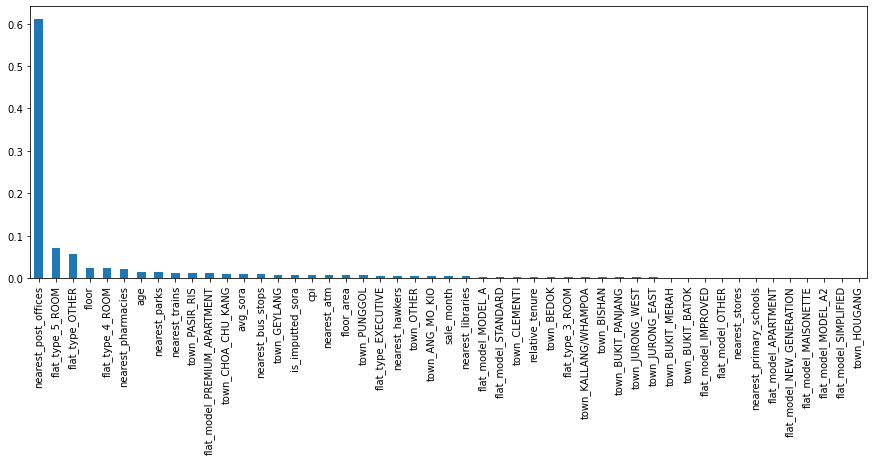

In [19]:
features_series = pd.Series(feature_impts.values(), index=feature_impts.keys())
features_series.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(15,5))
features_series.plot(kind = 'bar')
plt.show()

# Metrics

In [20]:
training_score = rfecv.score(X_train, y_train)

print('Decision Tree accuracy for training set: %f' % training_score)

Decision Tree accuracy for training set: 0.999089


In [21]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [22]:
y_pred = rfecv.predict(X_test)

mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 655076.0006245332
RMSE: 809.3676547926369
MAE: 581.8969884299179
R2: 0.6715776045072326
MAPE: 0.10652005019692831
MdAPE: 0.08579383861522376


# Actual vs Predicted

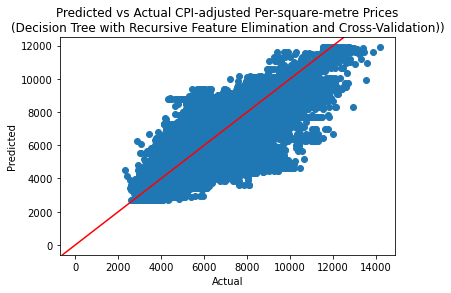

In [23]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Decision Tree with Recursive Feature Elimination and Cross-Validation))")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Recursive Feature Elimination Graph

C:\Users\Koon Kiat\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


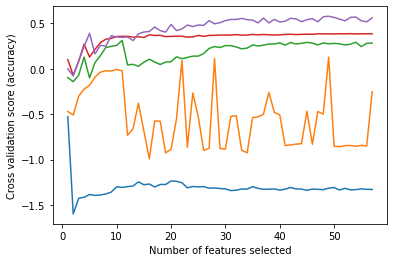

In [24]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.grid_scores_) + 1),
    rfecv.grid_scores_,
)
plt.show()